In [45]:
%matplotlib inline

import os
import time
import datetime
import glob
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import graphtools as gt
import phate
import magic

from scipy import sparse
from scipy.stats import zscore 

import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils

plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

In [2]:
# CTRL- 15162, 4092
# SCA1- 122, 132
# SCA3- 32, 33, 34, 35

In [3]:
pdfp = '/home/ngr4/project/scnd/data/processed/'
pfp = '/home/ngr4/project/scnd/results'
sc.settings.figdir = pfp

if True:
    adata = utils.load_adata(os.path.join(pdfp, 'hum_wsca3.h5ad'))

loaded @200904.12:44:59
took 9.34-s to load data


In [29]:
markers = {
    'Granule cell':['GABRA6','SLC17A7'],
    'Unipolar brush cell':['SLC17A6','EOMES'],
    'Purkinje cell':['ATP2A3','CALB1','CA8','PPP1R17','SLC1A6'],
    'Inhibitory interneuron':['GAD1','GAD2','NTN1','MEGF10'],
    'Astrocyte':['ALDH1L1','AQP4'],
    'Bergmann glia':['GDF10','HOPX'],
    'OPC':['OLIG1','OLIG2','PDGFRA'],
    'OL':['HAPLN2','MAG','MOG','OPALIN'],
    'Microglia':['C1QB','CX3CR1','DOCK2','P2RY12'],
    'Pericytes':['FLT1','RGS5'],
    'Endothelial cell':['DCN','LUM','KDR'],
}

In [36]:
sc.external.pp.bbknn(adata, n_pcs=100)
sc.tl.leiden(adata, resolution=4)

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


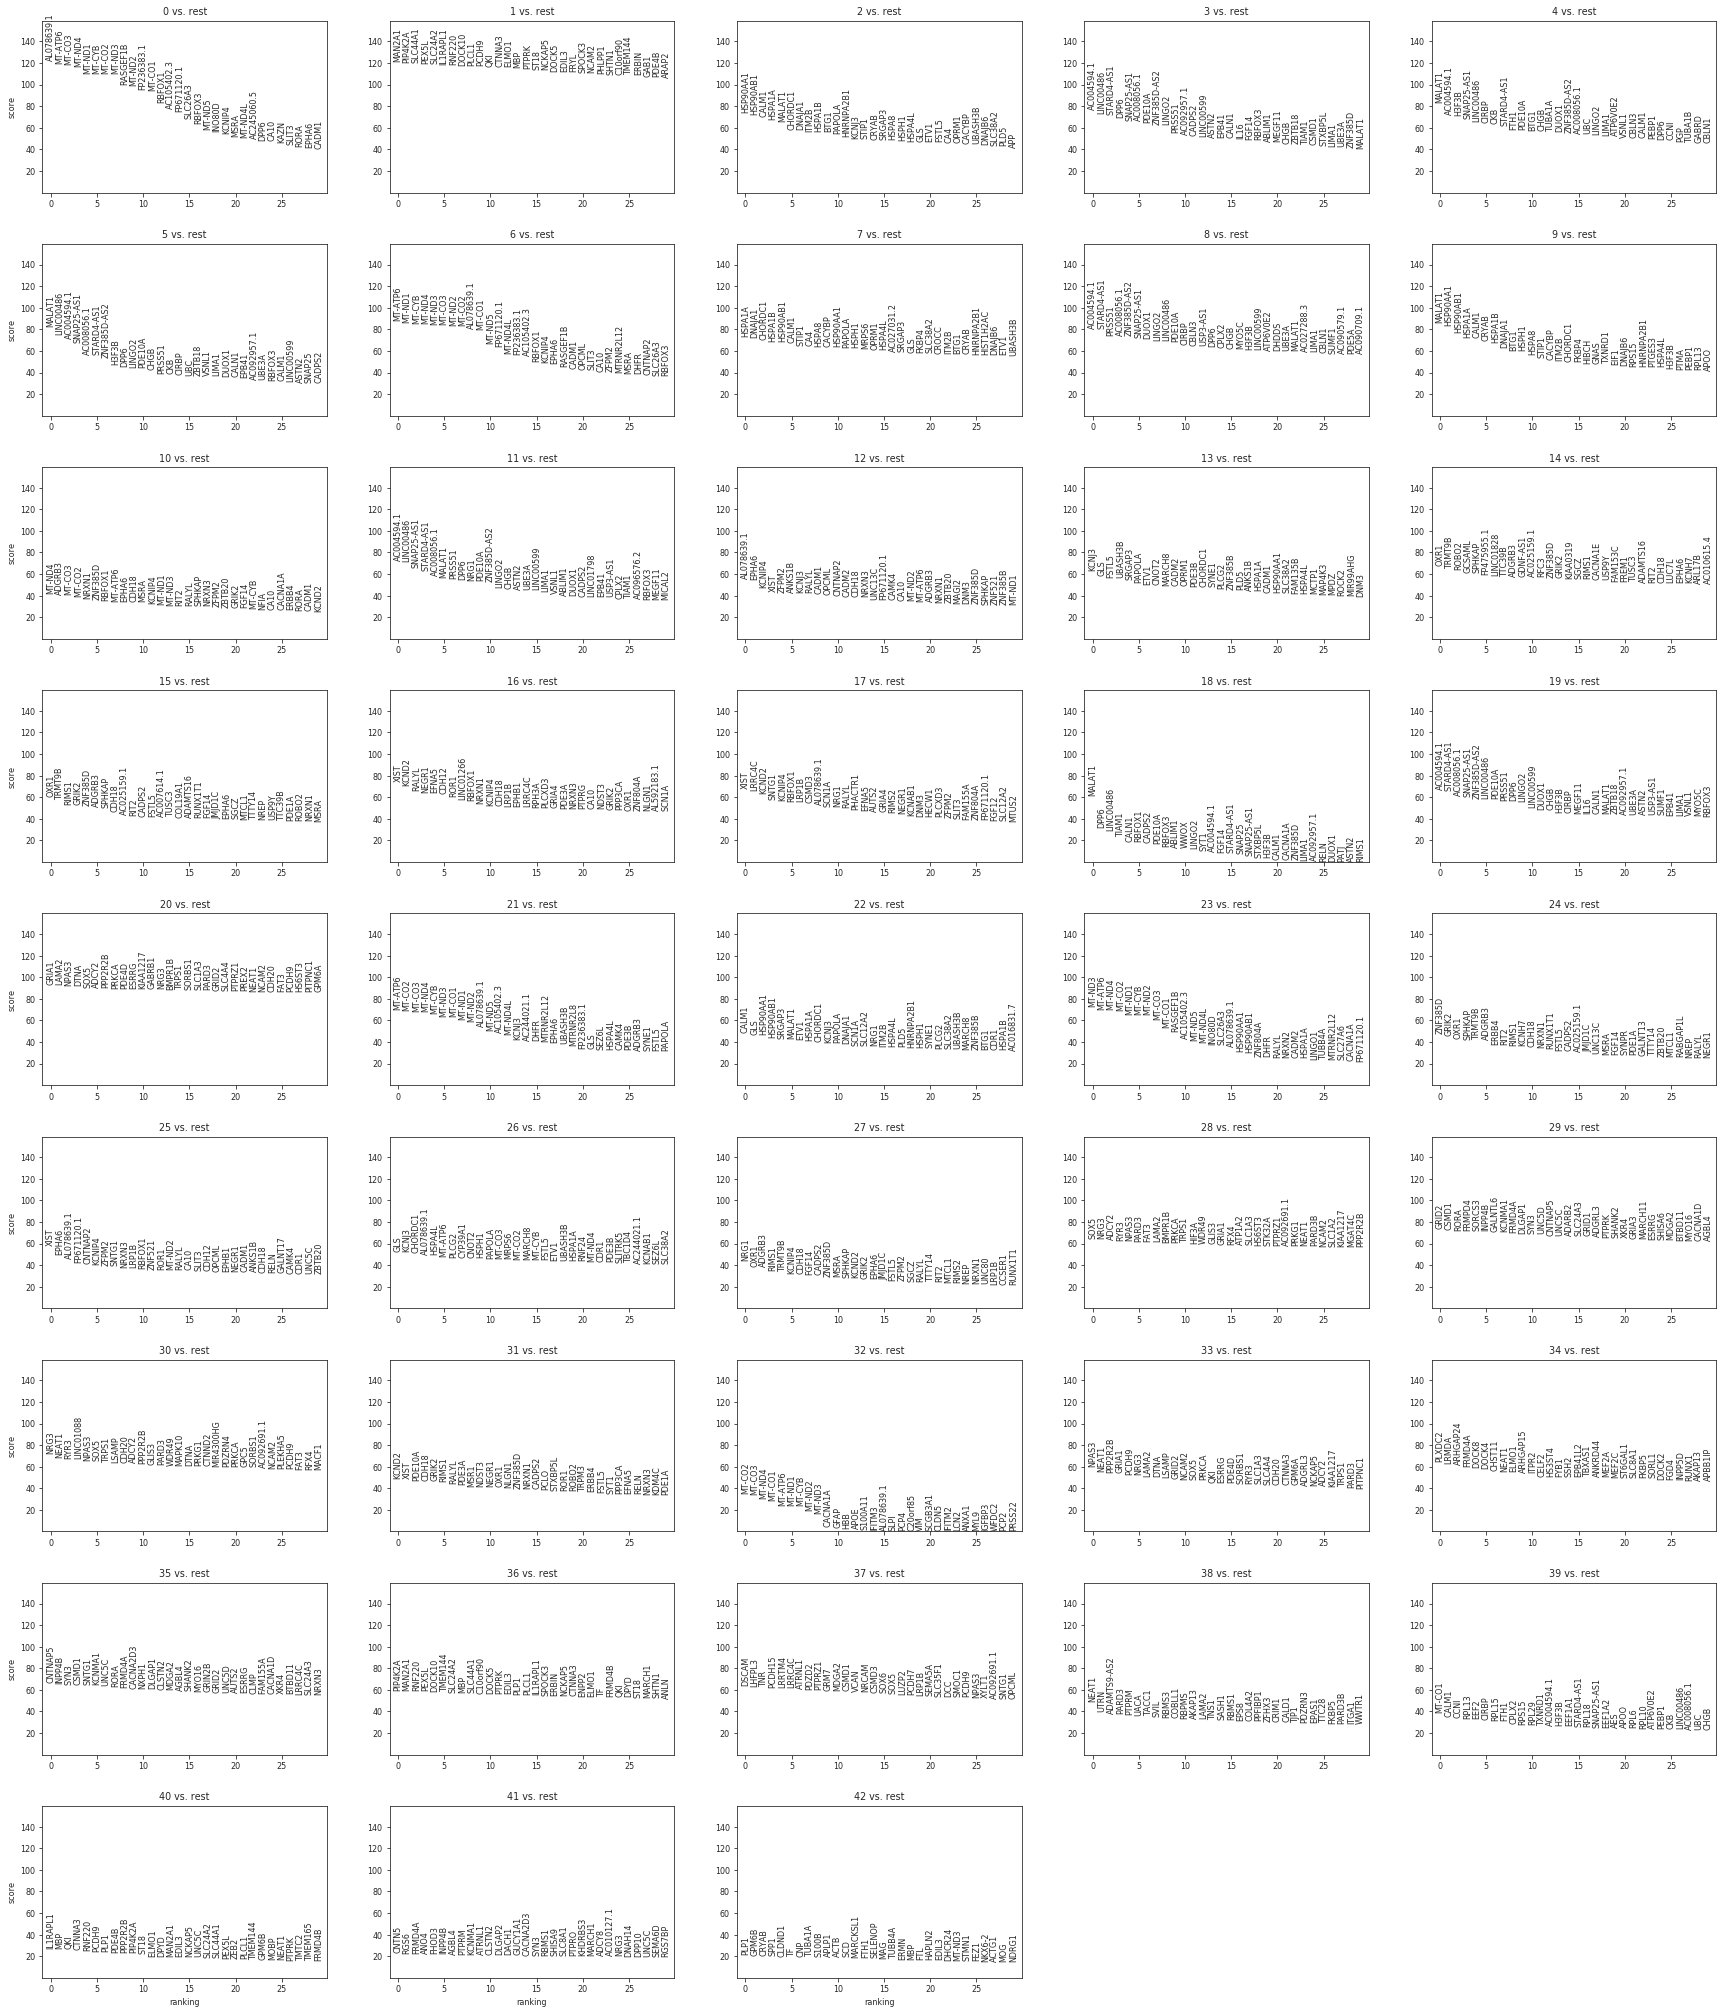

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', use_raw=False, groups='all', reference='rest', n_genes=100, rankby_abs=False, pts=False, key_added=None, copy=False, method='wilcoxon', corr_method='benjamini-hochberg', tie_correct=False, layer=None)
sc.pl.rank_genes_groups(adata, groups=None, n_genes=30, gene_symbols=None, key='rank_genes_groups', fontsize=8, ncols=5, sharey=True, show=None, save='_ctype_dge.pdf', ax=None)

In [30]:
marker_genes = [g for k,v in markers.items() for g in v]

X = pd.DataFrame(adata[:, marker_genes].X.todense(), columns=marker_genes, index=adata.obs.index)
G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
G.knn_max = None
magic_op = magic.MAGIC().fit(X=X,graph=G) # running fit_transform produces wrong shape
X_imputed = magic_op.transform(X,genes='all_genes')
del X

tdata = sc.AnnData(X=X_imputed)
tdata.obs.index = X_imputed.index
tdata.var_names = X_imputed.columns
tdata.obs = tdata.obs.merge(adata.obs, left_index=True, right_index=True)

Running MAGIC on 124463 cells and 33 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/magic/magic.py:594: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 1.15 seconds.


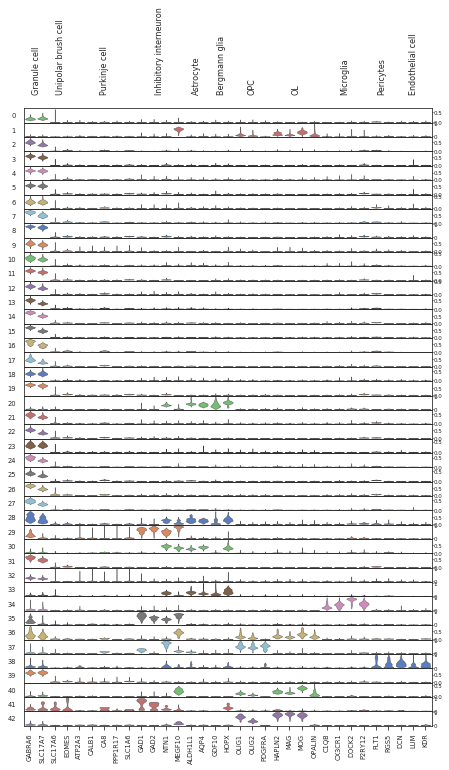

In [40]:
sc.pl.stacked_violin(tdata, markers, groupby='leiden', standard_scale='var', save='_markers_imputed.pdf')

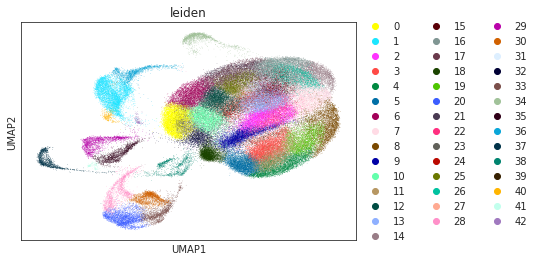

In [4]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'], save='_init_embeds.pdf')

In [43]:
adata.write(os.path.join(pdfp, 'hum_wsca3.h5ad'))

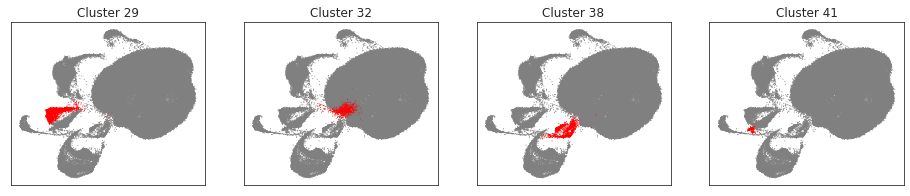

In [19]:
# plot individual clusters
cids = [str(i) for i in [29,32,38,41]]
cmap_clusters = {i:'gray' for i in adata.obs.leiden.unique()}

fig = plt.figure(figsize=(16, 3))

for i,cid in enumerate(cids):
    ax = fig.add_subplot(1,4, i+1)
    cmap_clusters[cid] = 'red'
    sns.scatterplot(
        x=adata.obsm['X_umap'][:,0],
        y=adata.obsm['X_umap'][:,1],
        hue=adata.obs['leiden'].astype(str),
        style=None,
        size=None,
        data=None,
        palette=cmap_clusters,
        hue_order=None,
        hue_norm=None,
        sizes=None,
        size_order=None,
        size_norm=None,
        markers=True,
        style_order=None,
        x_bins=None,
        y_bins=None,
        units=None,
        estimator=None,
        ci=95,
        n_boot=1000,
        alpha='auto',
        x_jitter=None,
        y_jitter=None,
        legend='brief',
        ax=ax,
        rasterized=True,
        linewidth=0, s=1,
    )
    ax.set_title('Cluster {}'.format(cid))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend().set_visible(False)
    cmap_clusters = {i:'gray' for i in adata.obs.leiden.unique()}

    

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


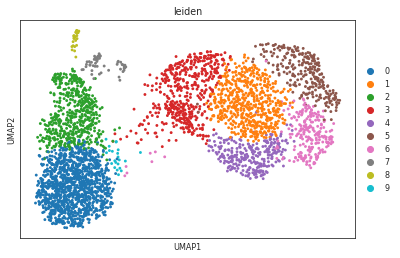

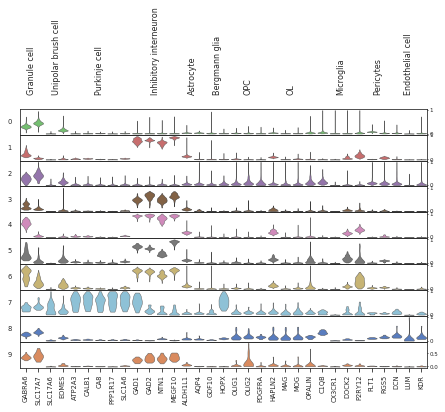

In [52]:
# subcluster 1
cids = [str(i) for i in [29,32]]
names = ''
for i in cids:
    names += i + '_'
tdata = sc.AnnData(adata[adata.obs['leiden'].isin(cids), :].X, obs=adata[adata.obs['leiden'].isin(cids), :].obs, var=adata.var) 

sc.tl.pca(tdata)
sc.external.pp.bbknn(tdata)
sc.tl.leiden(tdata)

ttdata = sc.AnnData(X=X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :])
ttdata.obs.index = X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :].index
ttdata.var_names = X_imputed.columns
ttdata.obs = ttdata.obs.merge(tdata.obs, left_index=True, right_index=True)

sc.tl.umap(tdata)
sc.pl.umap(tdata, color=['leiden'])
del tdata

sc.pl.stacked_violin(ttdata, markers, groupby='leiden', standard_scale='var', dendogram=True)

ttdata.obs.to_csv(os.path.join(pfp, 'subcluster_{}.csv'.format(names)))

del ttdata

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


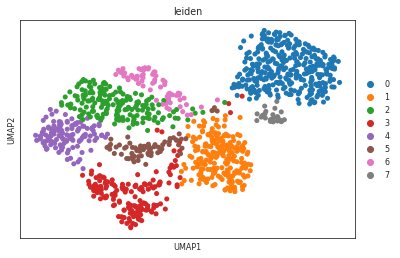

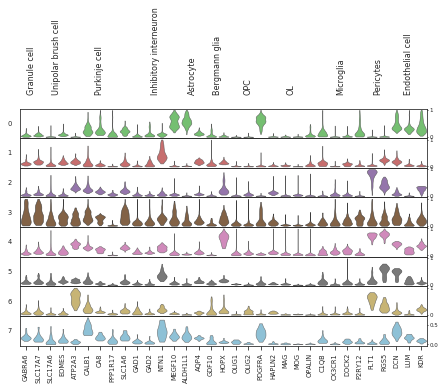

In [53]:
# subcluster 2
cids = [str(i) for i in [38]]
names = ''
for i in cids:
    names += i + '_'
tdata = sc.AnnData(adata[adata.obs['leiden'].isin(cids), :].X, obs=adata[adata.obs['leiden'].isin(cids), :].obs, var=adata.var) 

sc.tl.pca(tdata)
sc.external.pp.bbknn(tdata)
sc.tl.leiden(tdata)

ttdata = sc.AnnData(X=X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :])
ttdata.obs.index = X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :].index
ttdata.var_names = X_imputed.columns
ttdata.obs = ttdata.obs.merge(tdata.obs, left_index=True, right_index=True)

sc.tl.umap(tdata)
sc.pl.umap(tdata, color=['leiden'])
del tdata

sc.pl.stacked_violin(ttdata, markers, groupby='leiden', standard_scale='var', dendogram=True)

ttdata.obs.to_csv(os.path.join(pfp, 'subcluster_{}.csv'.format(names)))

del ttdata

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


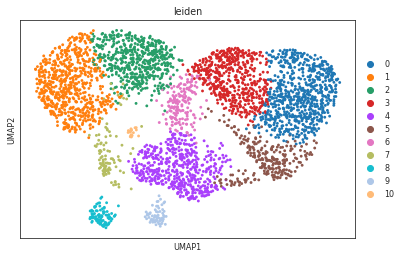

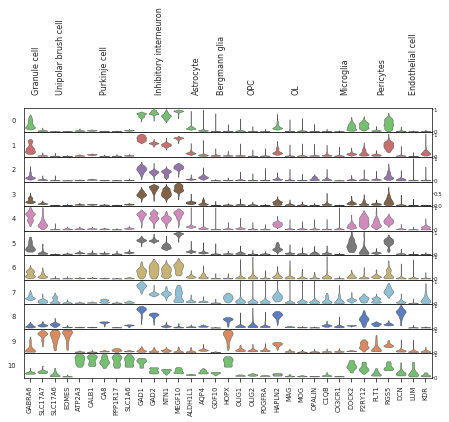

In [54]:
# subcluster 3
cids = [str(i) for i in [41,29,35]]
names = ''
for i in cids:
    names += i + '_'
tdata = sc.AnnData(adata[adata.obs['leiden'].isin(cids), :].X, obs=adata[adata.obs['leiden'].isin(cids), :].obs, var=adata.var) 

sc.tl.pca(tdata)
sc.external.pp.bbknn(tdata)
sc.tl.leiden(tdata)

ttdata = sc.AnnData(X=X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :])
ttdata.obs.index = X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :].index
ttdata.var_names = X_imputed.columns
ttdata.obs = ttdata.obs.merge(tdata.obs, left_index=True, right_index=True)

sc.tl.umap(tdata)
sc.pl.umap(tdata, color=['leiden'])
del tdata

sc.pl.stacked_violin(ttdata, markers, groupby='leiden', standard_scale='var', dendogram=True)

ttdata.obs.to_csv(os.path.join(pfp, 'subcluster_{}.csv'.format(names)))

del ttdata

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


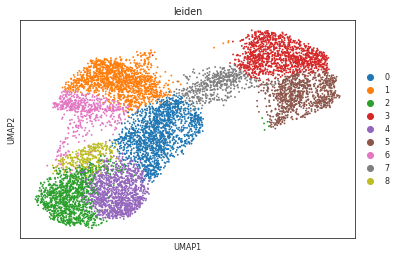

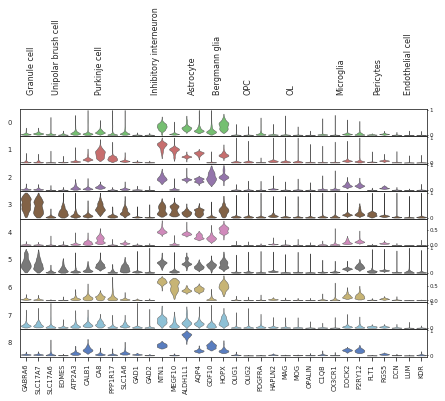

In [55]:
# subcluster 4
cids = [str(i) for i in [20,28,30,33]]
names = ''
for i in cids:
    names += i + '_'
tdata = sc.AnnData(adata[adata.obs['leiden'].isin(cids), :].X, obs=adata[adata.obs['leiden'].isin(cids), :].obs, var=adata.var) 

sc.tl.pca(tdata)
sc.external.pp.bbknn(tdata)
sc.tl.leiden(tdata)

ttdata = sc.AnnData(X=X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :])
ttdata.obs.index = X_imputed.loc[X_imputed.index.isin(tdata.obs.index), :].index
ttdata.var_names = X_imputed.columns
ttdata.obs = ttdata.obs.merge(tdata.obs, left_index=True, right_index=True)

sc.tl.umap(tdata)
sc.pl.umap(tdata, color=['leiden'])
del tdata

sc.pl.stacked_violin(ttdata, markers, groupby='leiden', standard_scale='var', dendogram=True)

ttdata.obs.to_csv(os.path.join(pfp, 'subcluster_{}.csv'.format(names)))

del ttdata